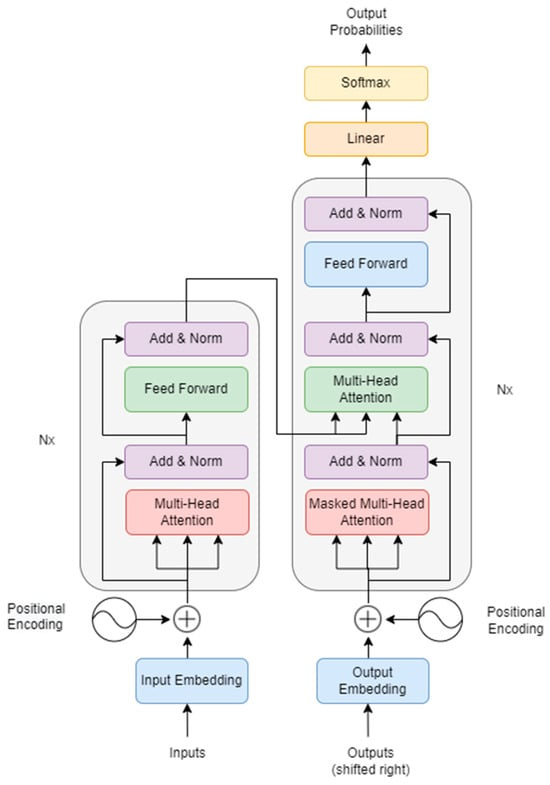

In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import torch.nn.functional as F

In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt


--2025-07-25 05:09:52--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.07s   

2025-07-25 05:09:52 (15.5 MB/s) - ‘input.txt’ saved [1115394/1115394]



encoder

In [3]:
with open('/content/input.txt', 'r', encoding='utf-8') as f:
    z = f.read()

In [85]:
class CharTokenizer:
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.stoi = {ch: i for i, ch in enumerate(self.chars)}
        self.itos = {i: ch for ch, i in self.stoi.items()}

    def encode(self, text):
        return [self.stoi[ch] for ch in text]

    def decode(self, tokens):
        return ''.join([self.itos[token] for token in tokens])

vocab = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,!?:;'\n-&3$#@э!?*")

In [86]:
tokenizer = CharTokenizer(vocab)

In [87]:
vocab_size = len(vocab)
tokens = torch.tensor(tokenizer.encode('hello world'), dtype=torch.long)
print(tokens.shape)

torch.Size([11])


In [96]:
print(vocab_size)

71


In [109]:
class Feed_forward(nn.Module):
  def __init__(self,n_embed):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embed,4*n_embed),
        nn.ReLU(),
        nn.Linear(4*n_embed,n_embed))
  def forward(self,x):
    return self.net(x)

class MHA(nn.Module):
  def __init__(self,heads,d_embed):
    super().__init__()
    self.heads = heads
    self.d_embed = d_embed
    self.d_k = d_embed // heads
    self.Wq = nn.Linear(d_embed,d_embed)
    self.Wk = nn.Linear(d_embed,d_embed)
    self.Wv = nn.Linear(d_embed,d_embed)
    self.Wa = nn.Linear(d_embed,d_embed)
  def forward(self,Q,K,V):
    batch_size = Q.size(0)
    Q = self.Wq(Q).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
    K = self.Wk(K).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
    V = self.Wv(V).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)

    scor = torch.matmul(Q,K.transpose(-2,-1)/torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32)))
    A = F.softmax(scor,dim = -1)
    output = torch.matmul(A,V)
    output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_embed)
    return self.Wa(output)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2048):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: (B, T, D)
        returns: positional encoding (1, T, D)
        """
        return self.pe[:, :x.size(1), :].to(x.device)

In [110]:
class Encoder(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    self.pos = PositionalEncoding(100)
    self.mha = MHA(4,100)
    self.norm = nn.LayerNorm(100)
    self.ff = Feed_forward(100)
    self.token_embedding = nn.Embedding(vocab_size, 100)
  def forward(self,x):
    x = self.token_embedding(x)
    x1 = self.pos(x)
    x2 = self.mha(x,x,x)
    x3 = x1 + x2
    x4 = self.norm(x3)
    x5 = self.ff(x4)
    x6 = x5 + x4
    x7 = self.norm(x6)
    #print(x7.shape)
    return x7

In [90]:
token_embedding = nn.Embedding(vocab_size, 100)
x =token_embedding(tokens)
print(x)

tensor([[ 1.5644, -1.8775, -1.5869,  ...,  0.6671, -1.2288, -1.4575],
        [ 0.1638, -0.7867, -0.6301,  ..., -0.8820, -0.9285,  0.5939],
        [ 1.5665,  0.2173,  0.6101,  ...,  0.1360, -0.2622, -1.6853],
        ...,
        [-1.7751,  2.6613, -1.7669,  ...,  0.1147, -0.4666, -0.9329],
        [ 1.5665,  0.2173,  0.6101,  ...,  0.1360, -0.2622, -1.6853],
        [-2.6244, -1.0503, -0.2963,  ...,  1.2746,  0.7934,  0.1875]],
       grad_fn=<EmbeddingBackward0>)


decoder

In [99]:
class mask_MHA(nn.Module):
  def __init__(self,heads,d_embed):
    super().__init__()
    self.heads = heads
    self.d_embed = d_embed
    self.d_k = d_embed // heads
    self.Wq = nn.Linear(d_embed,d_embed)
    self.Wk = nn.Linear(d_embed,d_embed)
    self.Wv = nn.Linear(d_embed,d_embed)
    self.Wa = nn.Linear(d_embed,d_embed)
  def forward(self,Q,K,V):
    batch_size = Q.size(0)
    Q = self.Wq(Q).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
    K = self.Wk(K).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
    V = self.Wv(V).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)

    scor = torch.matmul(Q,K.transpose(-2,-1)/torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32)))
    mask = torch.triu(torch.ones_like(scor), diagonal=1).bool()

    # Заменяем элементы выше диагонали на -inf
    scor.masked_fill_(mask, float('-inf'))
    A = F.softmax(scor,dim = -1)
    output = torch.matmul(A,V)
    output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_embed)
    return self.Wa(output)

In [111]:
class decoder(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    self.mmha = mask_MHA(4,100)
    self.norm = nn.LayerNorm(100)
    self.mha2 = MHA(4,100)
    self.ff2 = Feed_forward(100)
    self.lin = nn.Linear(100, vocab_size)
    self.pos = PositionalEncoding(100)
    self.token_embedding = nn.Embedding(71, 100)
  def forward(self,x,y):
    x = self.token_embedding(x)
    x1 = self.pos(x)
    x2 = self.mmha(x1,x1,x1)
    x3 = x1 + x2
    x4 = self.norm(x3)
    #print(x4.shape)
    x5 = self.mha2(x4,y,y)
    x6 = x5 + x4
    x7 = self.norm(x6)
    x8 = self.ff2(x7)
    x9 = x8 + x7
    x10 = self.norm(x9)
    x11 = self.lin(x10)
    x12 = F.softmax(x11,dim=-1)
    return x12

transformer

In [121]:
class Transformer(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    self.enc = Encoder(vocab_size)
    self.dec = decoder(vocab_size)
    self.vocab_size = vocab_size
  def forward(self,x):
    enc = self.enc(x)
    dec = self.dec(x,enc)
    return dec
  @torch.no_grad()
  def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self.forward(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx

In [122]:
model = Transformer(71)

In [132]:
def train(model, data, optimizer, criterion, epochs=1000, batch_size=32, block_size=32, device='cpu'):
    model.train()
    count  = 0
    for epoch in range(epochs):
        total_loss = 0
        for _ in range(len(data) // batch_size):
            ix = torch.randint(0, len(data) - block_size - 1, (batch_size,), device=device)
            block_size = 32
            x = torch.stack([data[i:i + block_size] for i in ix])           # shape [block_size]
            y = torch.stack([data[i + 1:i + block_size + 1] for i in ix]).unsqueeze(0)
           # print('y',y)
            optimizer.zero_grad()
            logits = model(x)
            """print("Logits shape:", logits.shape)
            print("Y shape:", y.shape)
            print("Logits view:", logits.view(-1, logits.size(-1)).shape)
            print("Y view:", y.view(-1).shape)"""
            #print('log',logits)
            #y = y.view(1)
            y = y[:, :, 0]
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            count += 1
         #   print(count)
            if count > 1500:
              break

        avg_loss = total_loss / (len(data) // batch_size)

        print(f"Epoch {epoch+1}: loss={avg_loss:.4f}")


In [131]:
tokens = torch.tensor(tokenizer.encode(z), dtype=torch.long)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [133]:

train(
    model = model,
    data = tokens,
    optimizer = optimizer,
    criterion = criterion
)


Epoch 1: loss=0.1781
Epoch 2: loss=0.0001
Epoch 3: loss=0.0001
Epoch 4: loss=0.0001
Epoch 5: loss=0.0001
Epoch 6: loss=0.0001
Epoch 7: loss=0.0001
Epoch 8: loss=0.0001
Epoch 9: loss=0.0001
Epoch 10: loss=0.0001
Epoch 11: loss=0.0001
Epoch 12: loss=0.0001
Epoch 13: loss=0.0001
Epoch 14: loss=0.0001
Epoch 15: loss=0.0001
Epoch 16: loss=0.0001
Epoch 17: loss=0.0001
Epoch 18: loss=0.0001
Epoch 19: loss=0.0001
Epoch 20: loss=0.0001
Epoch 21: loss=0.0001
Epoch 22: loss=0.0001
Epoch 23: loss=0.0001
Epoch 24: loss=0.0001
Epoch 25: loss=0.0001
Epoch 26: loss=0.0001
Epoch 27: loss=0.0001
Epoch 28: loss=0.0001
Epoch 29: loss=0.0001
Epoch 30: loss=0.0001
Epoch 31: loss=0.0001
Epoch 32: loss=0.0001
Epoch 33: loss=0.0001
Epoch 34: loss=0.0001
Epoch 35: loss=0.0001
Epoch 36: loss=0.0001
Epoch 37: loss=0.0001
Epoch 38: loss=0.0001
Epoch 39: loss=0.0001
Epoch 40: loss=0.0001
Epoch 41: loss=0.0001
Epoch 42: loss=0.0001
Epoch 43: loss=0.0001
Epoch 44: loss=0.0001
Epoch 45: loss=0.0001
Epoch 46: loss=0.00

In [134]:
def chat(model, tokenizer, prompt, max_new_tokens=500, device='cpu'):
    model.eval()
    input_ids = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=device)

    with torch.no_grad():
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens)

    output_text = tokenizer.decode(output_ids[0].tolist())
    return output_text

In [152]:

# пример запроса
prompt = "Before we"
response = chat(model, tokenizer, prompt, max_new_tokens=50)
print(response)

Before wedmbqCXUtэ@wOJBiyie,

R@?aqkRTOqW ?vAmaI
g?#eubLiqH
